# Triplet Loss

참고) https://github.com/andreasveit/triplet-network-pytorch

### 설계
- 두 방향의 triplet loss를 고려하고 있다.
    1. 같은 폰트를 구분하는가
    2. 같은 글자를 구분하는가 <br/>
    
    
2번의 경우 데이터가 많이 부족하다. (같은 글자는 전체 데이터셋에서 107개 뿐) <br/>
그러나 MNIST와 유사한 형태이기 때문에 데이터 수만 확보된다면 가능할 것 같긴 하다.


1번의 경우 각 폰트마다 2350개의 글자가 있기 때문에 이 방향으로 구현할 것이다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Tripletnet(nn.Module):
    def __init__(self, embeddingnet):
        super(Tripletnet, self).__init__()
        self.embeddingnet = embeddingnet

    def forward(self, x, y, z):
        embedded_x = self.embeddingnet(x)
        embedded_y = self.embeddingnet(y)
        embedded_z = self.embeddingnet(z)
        dist_a = F.pairwise_distance(embedded_x, embedded_y, 2)
        dist_b = F.pairwise_distance(embedded_x, embedded_z, 2)
        return dist_a, dist_b, embedded_x, embedded_y, embedded_z

## Triplet list 만들기
Triplet loss를 사용하기 위해서는 데이터셋을 triplet의 형태에 맞게 바꾸어야 한다. <br/>
https://github.com/andreasveit/triplet-network-pytorch/blob/master/triplet_mnist_loader.py


- triplet_list.txt 파일을 만들어야 한다.
- 한 줄당 3개의 index로 구성되어 있다.
- 각 index는 [anchor, negative, positive] 이미지의 인덱스이다.

In [5]:
from common.dataset import PickledImageProvider
from common.dataset import KoreanFontDataset

In [6]:
dset_train = KoreanFontDataset(PickledImageProvider('dataset/kor/train.obj'), vector_size=10)

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [9]:
dset_train[0][0]['font_index']

0

모든 데이터셋에서 font_index만 추출한다.

In [118]:
font_indexes_train = []
for i in range(len(dset_train)):
    font_indexes_train.append(dset_train[i][0]['font_index'])

In [119]:
font_indexes_train = np.array(font_indexes_train)

In [120]:
len(font_indexes_train)

202100

In [128]:
len(set(font_indexes_train))

86

In [129]:
def make_triplet_list(ntriplets, font_indexes, file_name):
    print('Processing Triplet Generation ...')
    np_labels = font_indexes 
    filename = file_name
 
    triplets = []
    font_size = int(ntriplets / 2350)
    for class_idx in list(set(np_labels)): # range(font_size): 
        try:
            a = np.random.choice(np.where(np_labels==class_idx)[0], int(ntriplets/font_size), replace=True) # 2350 anchor
            b = np.random.choice(np.where(np_labels==class_idx)[0], int(ntriplets/font_size), replace=True) # 2350 positive
            while np.any((a-b)==0):
                np.random.shuffle(b)
            c = np.random.choice(np.where(np_labels!=class_idx)[0], int(ntriplets/font_size), replace=True) # 2350 negative

            for i in range(a.shape[0]):
                triplets.append([int(a[i]), int(c[i]), int(b[i])]) # [anchor, negative, positive]           
        except Exception as e:
            print('exception font index:', class_idx)
            print(e)
    with open(os.path.join('./', filename), "w") as f:
        writer = csv.writer(f, delimiter=' ')
        writer.writerows(triplets)
    print('Done!')

In [130]:
make_triplet_list(202100, font_indexes_train, 'triplet_list_train.txt')

Processing Triplet Generation ...
Done!


## TrainLoader 커스텀
MNIST DataLoader를 커스텀하여 사용하기로 한다. <br/>
https://github.com/andreasveit/triplet-network-pytorch/blob/master/triplet_image_loader.py

In [131]:
from PIL import Image
import os
import os.path

import torch.utils.data
import torchvision.transforms as transforms

def default_image_loader(path):
    return Image.open(path).convert('RGB')

class TripletImageLoader(torch.utils.data.Dataset): 
    def __init__(self, pickled, triplets_file_name, base_path=None, filenames_filename=None, transform=None,
                 loader=default_image_loader):
        """ 
        filenames_filename: 
            A text file with each line containing the path to an image e.g.,
            images/class1/sample.jpg
                
        triplets_file_name: 
            A text file with each line containing three integers, 
            where integer i refers to the i-th image in the filenames file. 
            For a line of intergers 'a b c', a triplet is defined such that image a is more 
            similar to image c than it is to image b, 
            e.g., 0 2017 42 
        """
        self.dset = pickled.examples
#         self.base_path = base_path  
#         self.filenamelist = []
#         for line in open(filenames_filename):
#             self.filenamelist.append(line.rstrip('\n'))
        triplets = []
        for line in open(triplets_file_name):
            triplets.append((line.split()[0], line.split()[1], line.split()[2])) # anchor, far, close
        self.triplets = triplets
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        path1, path2, path3 = self.triplets[index]
        img1_tuple = self.dset[int(path1)]
        img2_tuple = self.dset[int(path2)]
        img3_tuple = self.dset[int(path3)]
        
        # byte만 사용할 예정
        img1, byte_1 = img1_tuple[0], img1_tuple[1]
        img2, byte_2 = img2_tuple[0], img2_tuple[1]
        img3, byte_3 = img3_tuple[0], img3_tuple[1]
        
        # bytes 타입을 numpy array로 변경 후 normalize
        img_arr_1 = np.array(Image.open(io.BytesIO(byte_1)))
        img_arr_1 = normalize_image(img_arr_1)
        
        img_arr_2 = np.array(Image.open(io.BytesIO(byte_2)))
        img_arr_2 = normalize_image(img_arr_2)
        
        img_arr_3 = np.array(Image.open(io.BytesIO(byte_3)))
        img_arr_3 = normalize_image(img_arr_3)

        cropped_image_1, cropped_image_size_1 = tight_crop_image(img_arr_1, verbose=False)
        centered_image_1 = add_padding(cropped_image_1, verbose=False)
        
        cropped_image_2, cropped_image_size_2 = tight_crop_image(img_arr_2, verbose=False)
        centered_image_2 = add_padding(cropped_image_2, verbose=False)
        
        cropped_image_3, cropped_image_size_3 = tight_crop_image(img_arr_3, verbose=False)
        centered_image_3 = add_padding(cropped_image_3, verbose=False)
            
        return centered_image_1, centered_image_2, centered_image_3

    def __len__(self):
        return len(self.triplets)

In [132]:
from common.utils import pad_seq, bytes_to_file, \
    read_split_image, shift_and_resize_image, normalize_image, \
    tight_crop_image, add_padding

import matplotlib.pyplot as plt
%matplotlib inline

In [133]:
pickled = PickledImageProvider('dataset/kor/train.obj')
triplet_loader_train = TripletImageLoader(pickled, 'triplet_list_train.txt')

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [134]:
len(triplet_loader_train)

202100

In [135]:
triplet_loader_train[0]

(array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]), array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]]))

In [136]:
len(triplet_loader_train[0])

3

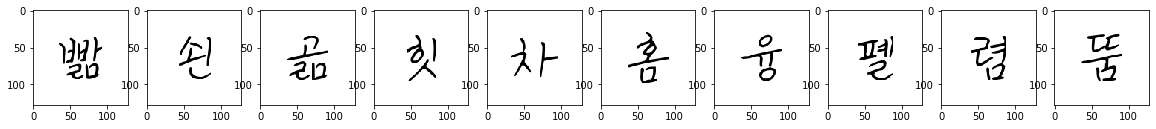

In [137]:
# anchor
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader_train[idx+5000][0], cmap='gray', label=idx)
plt.show()

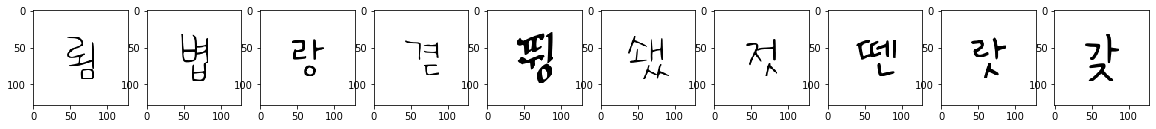

In [138]:
# negative: 위, 아래 폰트와는 다른 종류이다.
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader_train[idx+5000][1], cmap='gray', label=idx)
plt.show()

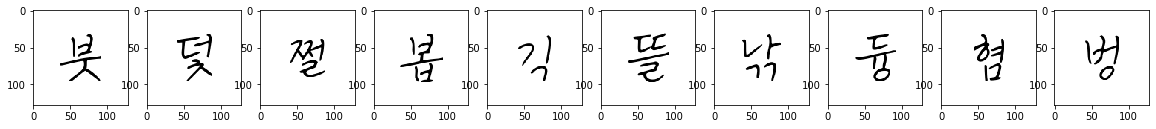

In [139]:
# positive
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader_train[idx+5000][2], cmap='gray', label=idx)
plt.show()

anchor, positive의 폰트는 같고 negative의 폰트는 다른 임의의 폰트이다.

---

## Train, val, test split
지금까지는 train data로만 만들었다. <br/>
val, test에 대해서도 상응하는 데이터를 만든다.

### val

In [140]:
dset_val = KoreanFontDataset(PickledImageProvider('dataset/kor/val.obj'), vector_size=10)

font_indexes_val = []
for i in range(len(dset_val)):
    font_indexes_val.append(dset_val[i][0]['font_index'])
font_indexes_val = np.array(font_indexes_val)

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [141]:
len(font_indexes_val)

37600

In [142]:
make_triplet_list(37600, font_indexes_val, 'triplet_list_val.txt')

Processing Triplet Generation ...
Done!


In [143]:
pickled = PickledImageProvider('dataset/kor/val.obj')
triplet_loader_val = TripletImageLoader(pickled, 'triplet_list_val.txt')

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [144]:
len(triplet_loader_val)

37600

### test

In [145]:
dset_test = KoreanFontDataset(PickledImageProvider('dataset/kor/test.obj'), vector_size=10)

font_indexes_test = []
for i in range(len(dset_test)):
    font_indexes_test.append(dset_test[i][0]['font_index'])
font_indexes_test = np.array(font_indexes_test)

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [146]:
len(font_indexes_test)

11750

In [147]:
make_triplet_list(11750, font_indexes_test, 'triplet_list_test.txt')

Processing Triplet Generation ...
Done!


In [148]:
pickled = PickledImageProvider('dataset/kor/test.obj')
triplet_loader_test = TripletImageLoader(pickled, 'triplet_list_test.txt')

processed 1000 examples
processed 2000 examples
processed 3000 examples
processed 4000 examples
processed 5000 examples
processed 6000 examples
processed 7000 examples
processed 8000 examples
processed 9000 examples
processed 10000 examples
processed 11000 examples
processed 12000 examples
processed 13000 examples
processed 14000 examples
processed 15000 examples
processed 16000 examples
processed 17000 examples
processed 18000 examples
processed 19000 examples
processed 20000 examples
processed 21000 examples
processed 22000 examples
processed 23000 examples
processed 24000 examples
processed 25000 examples
processed 26000 examples
processed 27000 examples
processed 28000 examples
processed 29000 examples
processed 30000 examples
processed 31000 examples
processed 32000 examples
processed 33000 examples
processed 34000 examples
processed 35000 examples
processed 36000 examples
processed 37000 examples
processed 38000 examples
processed 39000 examples
processed 40000 examples
processed

In [149]:
len(triplet_loader_test)

11750

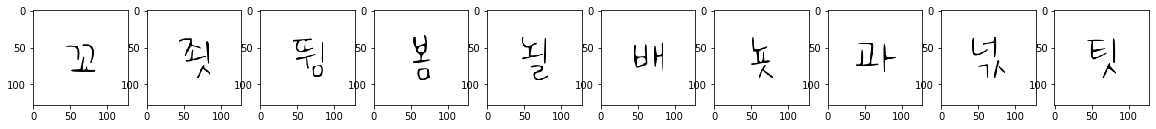

In [150]:
# anchor
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader_test[idx][0], cmap='gray', label=idx)
plt.show()

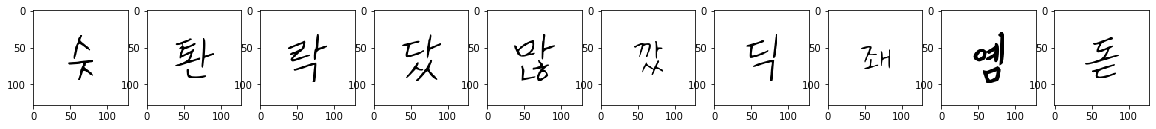

In [151]:
# negative: 위, 아래 폰트와는 다른 종류이다.
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader_test[idx][1], cmap='gray', label=idx)
plt.show()

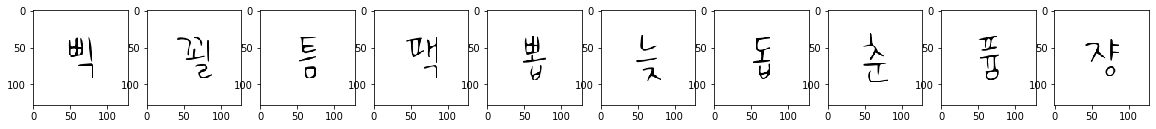

In [152]:
# positive
plt.figure(figsize=(20, 10))
for idx in range(10):
    plt.subplot(1, 10, idx+1)
    plt.imshow(triplet_loader_test[idx][2], cmap='gray', label=idx)
plt.show()